# 3. Evaluate Model

In [1]:
import keras

/home/dustin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/dustin/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from sklearn.metrics import confusion_matrix

In [3]:
import pandas as pd
import numpy as np
import pickle
import os

In [4]:
#pickle_path = 'Pickled/Small_Train/'

#pickle_path = 'Pickled/Train_Data/'

pickle_path = 'Pickled/Test_Data/'

# 3.1 Define data generator

In [5]:
# Returns i-th chunk of X,y data at path.
def Data_Gen(X_path, y_path):
        
    file = open(pickle_path + "Spectra/" + X_path,"rb")
    X=pickle.load(file)
    file.close()
    
    # I'm going to feed this into a pretrained Vgg16 model which expects a 3 channel image input.
    # Requires more memory, but less work. 
    X = np.stack((X,)*3, -1)
    
    
    file = open(pickle_path + "Targets/" + y_path,"rb")
    y=pickle.load(file)
    file.close()
    
    # Convert y to one-hot
    y = keras.utils.np_utils.to_categorical(y)        
    
    return X,y

# 3.2 Load & Test Previously Trained Model

In [10]:
model = keras.models.load_model("Model/Wingbeats_Cat_X_Entropy_V3.h5")

### The above model was trained all all ~18 GB of data

In [11]:
loss = []
accuracy = []

X_files = sorted(os.listdir(pickle_path + "Spectra"))
y_files = sorted(os.listdir(pickle_path + "Targets"))
iteration = 0

print("Working...")
for X,y in zip(X_files, y_files):
    
    X_test, y_test = Data_Gen(X, y)            
    results = model.evaluate(X_test, y_test, verbose=0)
    
    
    loss.append(results[0])
    accuracy.append(results[1])
    
    
    iteration+=1
    percent_complete = round(100*iteration/len(y_files), 2)
    print(str(percent_complete) + '% complete', end='\r', flush=True)
    

Working...


### Let's get some stats on the test data...

In [12]:
print("Mean Accuracy: " + str(round(np.mean(accuracy),3)))
print("2 sigma error: " + str(round(2*np.std(accuracy),3)))
print("Mean Loss: "     + str(round(np.mean(loss),3)))
print("2 sigma error: " + str(round(2*np.std(loss),3)))

Mean Accuracy: 0.755
2 sigma error: 0.026
Mean Loss: 0.781
2 sigma error: 0.084


### Gets an accuracy of about 75%... Lets's see where things go awry.

# 3.3 Confusion Matrix

In [13]:
y_pred=[]
y_true=[]

iteration = 0

for X,y in zip(X_files, y_files):
    
    X_test, y_test = Data_Gen(X, y)            
    predicted_class=model.predict(X_test)

    for predicted, true in zip(predicted_class, y_test):
    
        y_pred.append(np.argmax(predicted))
        y_true.append(np.argmax(true))
        
    iteration+=1
    percent_complete = round(100*iteration/len(y_files), 2)
    print(str(percent_complete) + '% complete', end='\r', flush=True)


In [20]:
CM = confusion_matrix(y_pred,y_true)

CM = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]

In [21]:
import seaborn as sn
import matplotlib.pyplot as plt

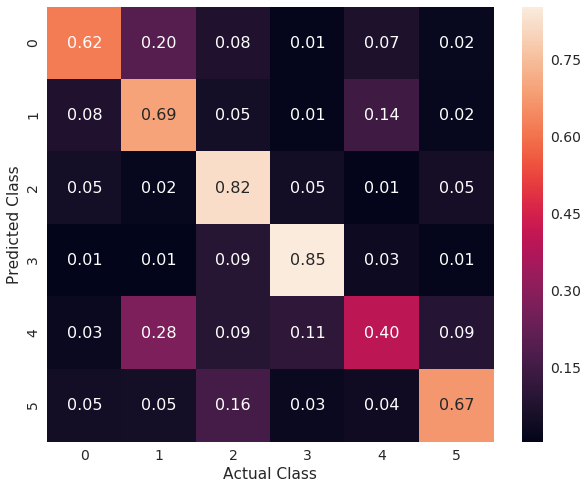

In [23]:
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)
sn.heatmap(CM, annot=True, annot_kws={"size": 16}, fmt='.2f')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class')

plt.show()

### The confusion matrix reveals that: 
1. Classes 2 and 3 have the best performance.
2. Class 4 shows the worst performance.
3. Class 1 gets mislabeled as 0 or 4 at a rate of 48%.
4. Class 4 gets mislabeled as 1 at a rate of 14%. 



### Definitely room for improvement. 

### What are the total numbers for each class in the training data anyway?

In [24]:
totals = np.zeros(6)
for num in y_true:
    
    totals[num] += 1
    
print(totals)

[1001. 2367. 4020. 3539.  909. 1476.]


### Clearly some classes are weighted heavier than others. If this is true for the training data, then what about the test data?

In [25]:
#pickle_path = 'Pickled/Small_Train/'

pickle_path = 'Pickled/Train_Data/'

#pickle_path = 'Pickled/Test_Data/'

In [37]:
X_files = sorted(os.listdir(pickle_path + "Spectra"))
y_files = sorted(os.listdir(pickle_path + "Targets"))

totals = np.zeros(6)
iteration = 0

for X,y in zip(X_files, y_files):
    
    X_test, y_test = Data_Gen(X, y)            
 
    for cat in y_test:
        
        totals[np.argmax(cat)] += 1
    
    iteration+=1
    print(iteration)
        
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


In [46]:
totals_normalized=[]
for total in totals:
    
    totals_normalized.append(total/sum(totals))
    

In [51]:
['%.3f' % elem for elem in totals_normalized]

['0.073', '0.177', '0.306', '0.267', '0.069', '0.109']

### The training and test data have similar proportians of class numbers. I suspect that the model is not generalizing well because of the asymmetry of training data. About 57% of data used to train the model belongs to classes 2 and 3.  

# 3.4 Possible Future Steps

### To get better performance, there are a few things I would like to try:

1. Retrain model with equal proportions of training data
2. Learn how to add Temperature and Humidity data from file names 
3. Consider trying different pretrained networks, or make one from scratch.
4. Finetune Block 4 layers with a very small learning rate to try and optimize feature extraction. 